#  Things I Learned
-  Bigram model
-  multilayer perceptron (MLP)
-  pytorch module like multinomial,view etc
-  Vector Embedding (lookup table) based on paper a A Neural Probabilistic Language Model
-  Learned about Kaiming initialization for better intialization 
-  Learned about batch normalization to make neural net more robust
-  pytorchification of neural network
-  why we need to properly tune the learning rate even introducing the batchnorm
-  Implementing back pass manually instead of loss.backward() on tensor level 


# Papers
- ## [Based on paper A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- ## [Batch Normalization](https://arxiv.org/pdf/1502.03167)

# [Based on paper A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- This paper popularised the vector embedding conecpt solving the curse of dimensionality (due to one hot encoding)
- A lookup table was used to map words to their vector embeddings, which were then updated during training to optimize the language modeling task.
- The embedding captured semantic and syntactic relationships between words

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab and characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#build dataset 
# context length: how many characters do we take to predict next one
block_size = 3
X,Y = [],[]
for w in words:
    
    # print(w)
    context = [0]* block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context),'--->',itos[ix])
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [7]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [8]:
C = torch.randn([27,2])

In [9]:
C

tensor([[-0.5201,  1.1852],
        [ 0.4228, -0.0351],
        [ 0.7189, -0.3690],
        [-0.3590, -0.3389],
        [ 0.0271, -0.7383],
        [-1.7090,  1.5560],
        [-0.0697,  2.1302],
        [ 0.6551, -1.2155],
        [-0.9807, -2.1953],
        [ 0.8809, -0.9304],
        [-1.5670, -1.0453],
        [-2.2406, -0.3851],
        [-0.4672,  0.4771],
        [ 0.2966,  0.3212],
        [-1.0828, -0.7290],
        [ 1.2022,  0.3337],
        [ 1.6219, -0.7433],
        [-0.5138,  0.4441],
        [-0.5755,  0.5822],
        [ 1.8547,  0.9411],
        [-2.1645, -1.1413],
        [-1.7215, -0.6527],
        [ 0.4208,  1.1688],
        [ 1.3796,  1.3323],
        [-0.9821, -0.2291],
        [-1.3511, -0.0552],
        [ 0.4690, -0.1942]])

In [10]:
#Mapping the X character block (indices) to a 2D vector representation using the embedding lookup table.
#hence no need one hot encoding,thus good for generalization
embed = C[X]
embed.shape


torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)
embed.shape

torch.Size([228146, 3, 2])

In [12]:
# to embed the input layer options
torch.cat([embed[:,0,:],embed[:,1,:],embed[:,2,:]],1).shape
torch.cat(torch.unbind(embed,dim=1),1).shape
#best options is to use tensor.view as it rearrange feature for the tensor only
# -1 or embed.shape[0]
embed.view(-1,6)

tensor([[-0.5201,  1.1852, -0.5201,  1.1852, -0.5201,  1.1852],
        [-0.5201,  1.1852, -0.5201,  1.1852, -1.7090,  1.5560],
        [-0.5201,  1.1852, -1.7090,  1.5560,  0.2966,  0.3212],
        ...,
        [ 0.4690, -0.1942,  0.4690, -0.1942, -1.3511, -0.0552],
        [ 0.4690, -0.1942, -1.3511, -0.0552,  0.4690, -0.1942],
        [-1.3511, -0.0552,  0.4690, -0.1942, -0.9821, -0.2291]])

In [13]:
#hidden layer
h = embed.view(-1,6) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [14]:
#output layer
W2 = torch.randn(100,27)
b2 = torch.randn(27)


In [15]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [16]:
counts = logits.exp()
prob = counts/counts.sum(dim=1,keepdim=True)

In [17]:
prob.shape

torch.Size([228146, 27])

In [18]:
torch.arange(16)
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [19]:
# loss = - prob[torch.arange(16),Y].log().mean()
# loss

# Build dataset and splitting

In [20]:
# build the vocab and characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [21]:
block_size = 3 #context length: how many character do we take to predict the next one ?

def build_dataset(words):
# context length: how many characters do we take to predict next one
    X,Y = [],[]
    for w in words:
        
        # print(w)
        context = [0]* block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',itos[ix])
            context = context[1:] + [ix] #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xval,Yval = build_dataset(words[n1:n2])
Xtest,Ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Steps to optimize the loss (thoughts process/took steps)
### For lr=-0.1, hidden_layer = 100,vector_embedding(C)=2
 - the loss converges at about 2.58 after training alots of time.
 - Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.29
 - Still model is Underfitting(might be due to model being to simple bump hidden layer to 300)
### For lr = -0.1,hidden_layer=300,vector_embedding(C)=2
 - the loss converges at about 2.41 after training 8*10000 times.
 - Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.24
 - Loss is not decreasing,still model is Underfitting(might be due to vector embedding in 2d creating a bottle neck)
### For lr = -0.1,hidden_layer=200,vector_embedding(C)=10
- after training 8*10000 times loss converges at about 2.22
- Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.06
- which is much better parameters than previous hyperparameters

### Implemented Kaiming Intialization for better intialization
- In Kaiming Initialization (or He Initialization), the gain is a scaling factor used to adjust the magnitude of the weights based on the activation function being used
- The gain is a multiplier applied to the weights during initialization to further adjust their scale
- check torch documentation on kaiming initialization on gain
### Implemented BatchNormalization for further bettter performance


In [22]:
# writing all about neural net layer here
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) #for reproducibility
#C is a lookup table for vector embedding the words
    C = torch.randn(vocab_size,n_embd,generator=g)

#input layer x hidden layer
#according to kaiming paper for proper initialization of weights   # gain/(fan_in)**0.5  
W1 = torch.randn(block_size*n_embd,n_hidden,generator=g) *        (5/3)/((block_size*n_embd)**0.5)

#b1 is negated in due to batchnorm as batch norm have its own bias thus commented
# b1 = torch.randn(n_hidden,generator=g) * 0

#hidden layer x output layer
W2 = torch.randn(n_hidden,vocab_size,generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0 
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias]
print('total number of parameters: ',sum(p.nelement() for p in parameters)) #number of parameters

for p in parameters:
    p.requires_grad = True

total number of parameters:  12097


In [23]:
sum(p.nelement() for p in parameters)
print(X.shape[0])


228146


In [24]:
# selecting learning rate
# lre = torch.linspace(-3,0,1000)
# lre = 10 **lre 


## Mini Batch size Training
- 32 batchsize of data are being processed at a time more efficient and faster for processing the dataset.
- as processing all the dataset(very large) is inefficient and memory intensive not worth it.


In [25]:
track_loss = []
track_epoch = []
max_steps = 200000
batch_size=32
for epoch in range(max_steps):
    #mini batch construct processing 32 batchsize of dataset a time more efficient
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix] #batch X,Y
    
    #forward pass
    embed = C[Xb] #embed the characters into vectors
    embcat = embed.view(-1,block_size*n_embd) #cocatenate the vectors
    
    #tanh on hidden layer on paper
    hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation
    
    #batch norm layer
    # ======================
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + bnmeani * 0.001
        bnstd_running = 0.999 * bnstd_running + bnstdi * 0.001
    # ========================
    
    # non linearity 
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits,Yb) #loss function
     
    # pytorch own cross entropy function
    # counts = logits.exp()
    # prob = counts / counts.sum(1,keepdims=True)
    # loss =- prob[torch.arange(16),Y].log().mean()

    
    #backward pass
    #need to reset gradient for every steps due to different position of loss
    for p in parameters:
        p.grad = None
    loss.backward()
        
    #step learning rate decay
    lr = 0.1 if epoch<100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad

    #track stats
    if epoch % 10000 == 0:
        print(f'{epoch:7d}/{max_steps:7d}: loss = {loss.item():.4f}')
        track_epoch.append(epoch)
    # track_lre.append(lre[epoch])
    track_loss.append(loss.log10().item())



      0/ 200000: loss = 3.3239
  10000/ 200000: loss = 2.0322
  20000/ 200000: loss = 2.5675
  30000/ 200000: loss = 2.0125
  40000/ 200000: loss = 2.2446
  50000/ 200000: loss = 1.8897
  60000/ 200000: loss = 2.0785
  70000/ 200000: loss = 2.3681
  80000/ 200000: loss = 2.2918
  90000/ 200000: loss = 2.0238
 100000/ 200000: loss = 2.3673
 110000/ 200000: loss = 2.3132
 120000/ 200000: loss = 1.6414
 130000/ 200000: loss = 1.9311
 140000/ 200000: loss = 2.2231
 150000/ 200000: loss = 2.0027
 160000/ 200000: loss = 2.0997
 170000/ 200000: loss = 2.4949
 180000/ 200000: loss = 2.0199
 190000/ 200000: loss = 2.1707


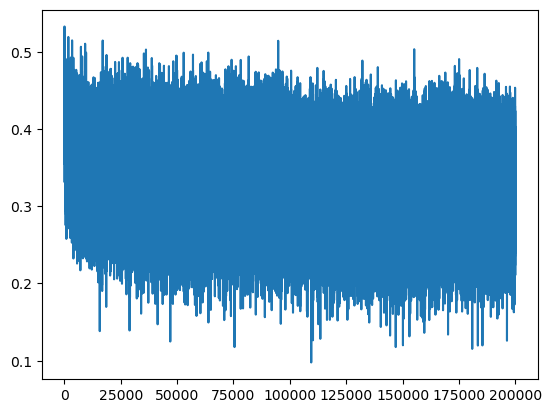

In [26]:
plt.plot(track_loss)
# plt.plot(track_epoch,track_loss)
plt.show()


In [27]:
#calibrate the batch norm at the end of training
# instead of this bnmean_running and bnstd_running is maitained over the training set so that we dont need to calulate
# batch mean and batch std when inferencing
# with torch.no_grad():
    # emb = C[Xtr]
    # embcat = emb.view(emb.shape[0],-1)
    # hpreact = embcat @ W1 + b1
    #measure mean/std over the entire training set
    # bnmean = hpreact.mean(0,keepdim=True)
    # bnstd = hpreact.std(0,keepdim=True)


In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 # + b1
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs[0], num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


mora.
mayah.
seel.
ndheyah.
reisha.
endraeg.
adelynnelin.
shy.
jen.
eden.
sana.
arleigh.
malaia.
nosadhvighairiel.
kindreelynn.
novana.
uberted.
ryyah.
faeha.
kayshayklynn.


## Visualizing graphs
1. You can see change the gain and visualize the graph eg: for gain=1 for tanh its quite bad than gain=5/3.Note that, **for good learning layer of neural net have roughly gussian distribution of graph**,hence maitaining such distribution will yield better result. Comment out/remove BatchNorm1d when making the neural net layer.
3. Comment out the fan_in from the layer then you can visualize worst distribution of gradient,activation and learning rate of params
4. For checking learning rate of params the properly learning param is close to -3.0 threshold. Closer is it to -3.0 the stable. check comment on ud update by p.grad to p.data i.e by how much does the gradient updates the parameters data. $$ std(update) << std(parameter)$$ **slower learning rate can cause vanishing gradient above equation** $$std(update)>>std(parameters)$$ **larger learning rate can cause exploding gradient above equation**  $$log10(std(update)/std(parameter))$$ **best case is log10 value is near to 0 hence we get balance learning rate and paramter scale in above equation**
6. Introduce batch normalization then our neural network becomes more roboust thus making our task easier even when gains is not set properly or fan_in is commented out. You can verify.You can experiment it by changing the gain or remove fan_in things but you will observe quite good distribution in gradient,activation,weights gradient. Note that, batch normalization introduces gamma,beta and epislon.
7. **Even using batchnorm it is necessary to set the learning rate properly as it doesnot give robustness when setting for learning rate**. Thus, so far now as I have seen we usually do hyperparameter tuning on learning rate because other parameters are made robust by batchnorm


In [30]:
# pytorchifying the above batchnorm 
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps #for numerical stability in paper
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [31]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # The calulate ratio of the update scale to the current parameter scale.
  # It tells us how significant the updates are relative to the parameter values
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


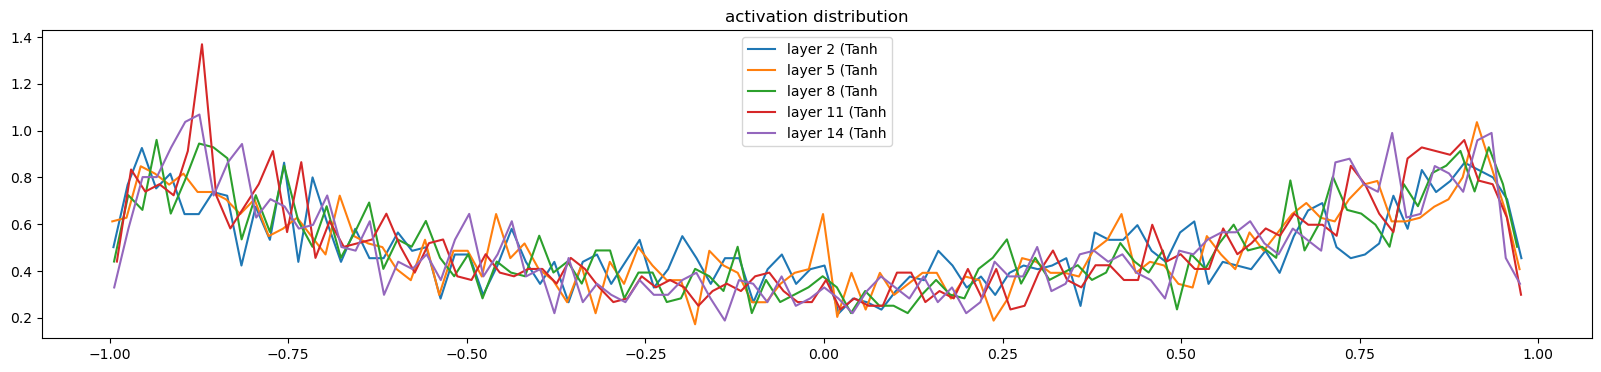

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show();

layer 2 (      Tanh): mean +0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean +0.000000, std 1.952381e-03


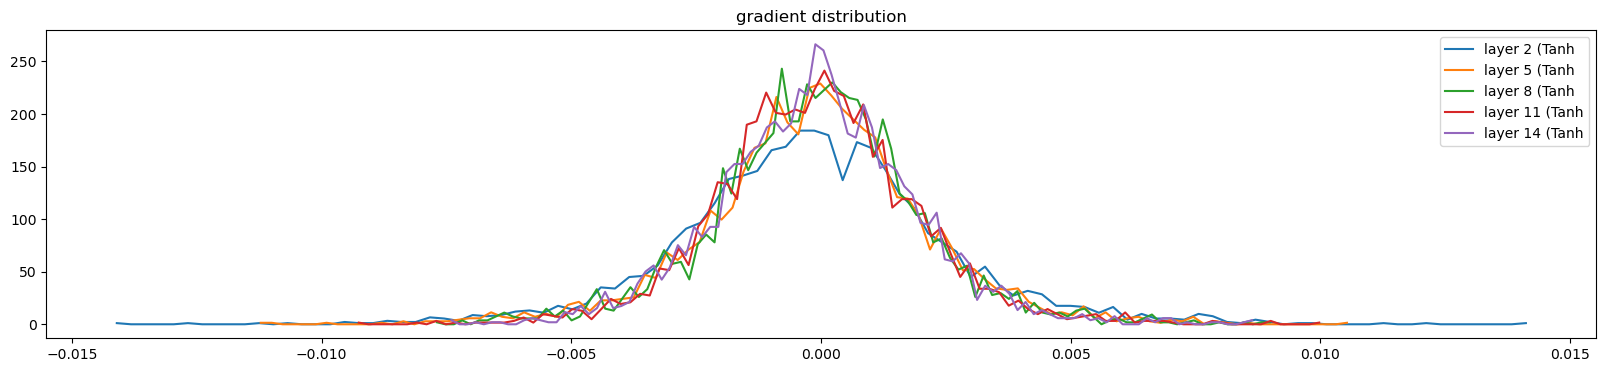

In [33]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
plt.show();

weight   (27, 10) | mean -0.000000 | std 8.020526e-03 | grad:data ratio 8.012622e-03
weight  (30, 100) | mean +0.000246 | std 9.241071e-03 | grad:data ratio 4.881087e-02
weight (100, 100) | mean +0.000113 | std 7.132874e-03 | grad:data ratio 6.964615e-02
weight (100, 100) | mean -0.000086 | std 6.234300e-03 | grad:data ratio 6.073736e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570122e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


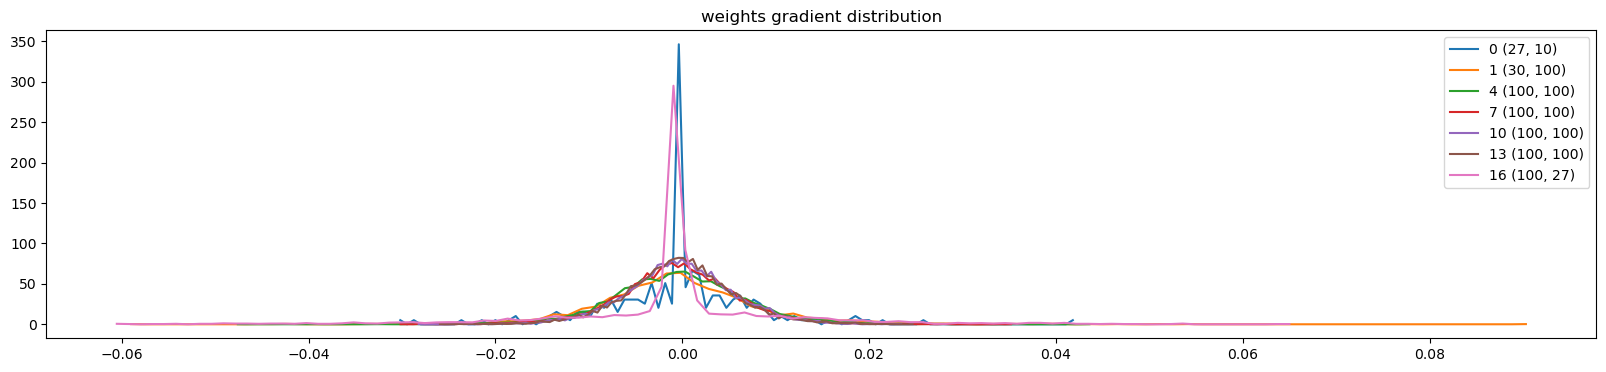

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show();


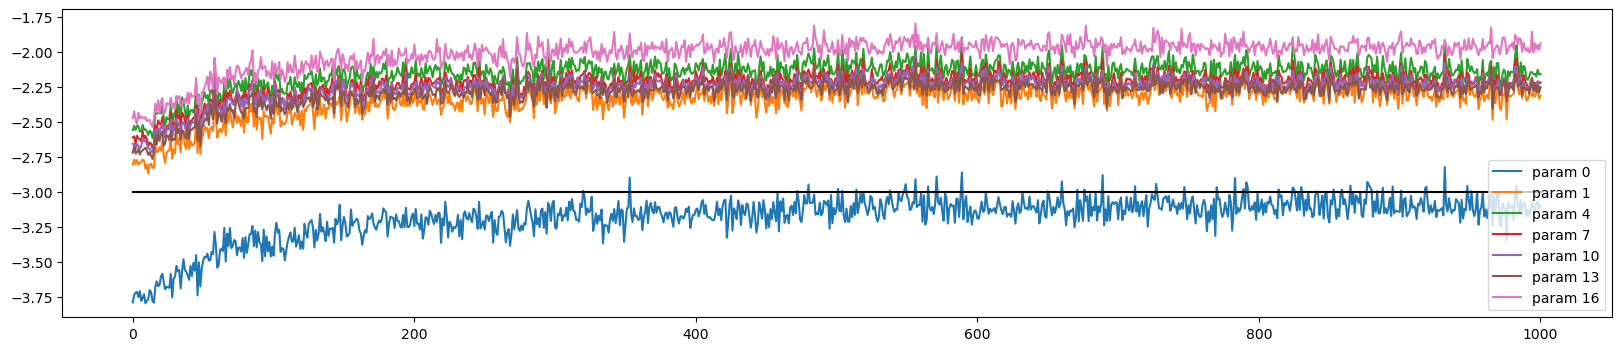

In [35]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.show();

In [35]:
embed = C[Xtr]
h = torch.tanh(embed.view(-1,) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

RuntimeError: The size of tensor a (200) must match the size of tensor b (100) at non-singleton dimension 1

In [36]:
embed = C[Xval]
h = torch.tanh(embed.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Yval)
loss

RuntimeError: The size of tensor a (200) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:
embed = C[Xtest]
h = torch.tanh(embed.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytest)
loss

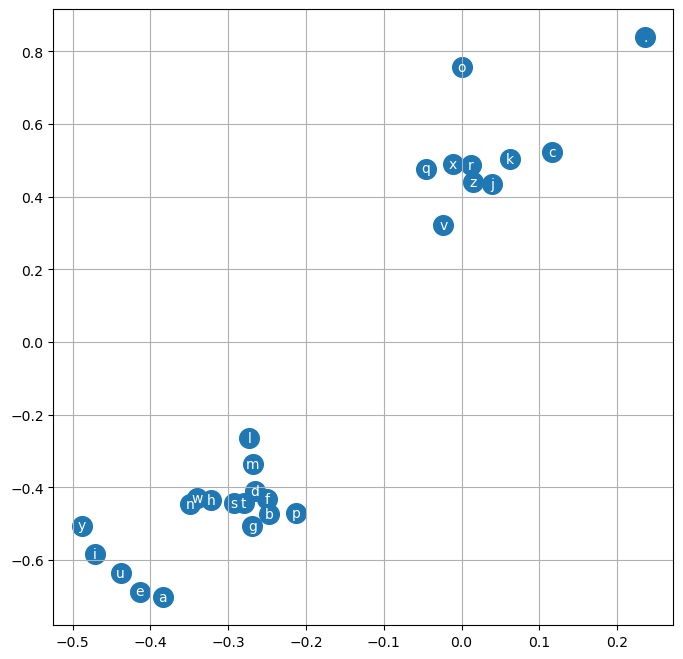

In [261]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# this visualize only works when C is 2d

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

# Interpretation of above graph
- Some commonly repeated words are cluster together in 2d vector embedding from lookup table C
- eg. a,e,i,o,u are vowel and closely related hence scatter together, '.' is special character so it is very further away from all others characters 